### Aplicando método de otimização para ajuste do modelo
### Argentina - Dados de Óbitos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
# sigmoid.py (https://github.com/fpelogia/epid-models/blob/master/sigmoid.py)
from sigmoid import f_t, deriv_f_t 
# new_wave.py (https://github.com/fpelogia/epid-models/blob/master/new_wave.py)
from new_wave import new_wave_detection, filter_data, forward_euler, moving_average 
plt.rcParams.update({'font.size': 14})

In [7]:
#import data
data = pd.read_csv("Datasets/buenos_aires_obitos.csv") 
city_name = 'Buenos Aires' 

acc_data = data.cumulative_deceased
normalized_acc_data = acc_data / max(acc_data)
t = np.linspace(0, len(acc_data)-1, len(acc_data))

daily_data = data.new_deceased.tolist()

# for the "one wave" tests
model = f_t
n_days = 300 

In [8]:
# plt.title('Casos confirmados - SJC / SP / Campinas')
# plt.boxplot(acc_data)
# data = pd.read_csv("Datasets/sp.csv")  
# sp = data.total_confirmed
# data = pd.read_csv("Datasets/campinas.csv")  
# camp = data.total_confirmed
# plt.boxplot([acc_data, sp, camp])
# plt.show()

### 1 - Uma onda epidemiológica

#### 1.1 - Definindo o problema de otimização
Definiremos uma função para descrever a perda do modelo em relação aos dados reais. Ela será a função objetivo do problema de minimização.

Seja o vetor x de parâmetros:
$$x = [A\quad \nu\quad \delta\quad t_p]^T$$
Problema de otimização descrito no artigo da ASOC:
$$min \sum_{t=0}^{t=t_{end}} t(y_t(t) - y_m(t, x))^2$$ 

$$\textrm{s.t.}\quad A \geq 0,\\\quad\quad\ \nu > 0,\\\quad\quad\ \delta > 0,\\\quad\quad\  t_p \geq 0$$ 

Ao invés de utilizarmos a função objetivo apresentada (ITSE), _utilizaremos a Mean Squared Error_ (MSE), que pode ser formulada da seguinte forma:
$$MSE(x) = \sum_{t=0}^{t=t_{end}} (y_t(t) - y_m(t, x))^2$$

A otimização será feita em duas etapas:
- 1 - Otimizar uma sigmoide simétrica ($\nu$ = 1)
- 2 - Otimizar uma sigmoide assimétrica, utilizando o ponto ótimo da etapa 1 como ponto inicial.

Para a implementação, estamos utilizando a função [minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
) do pacote do otimização da biblioteca Scipy. O método de otimização utilizado é o _Sequential Least Squares Programming_ (SLSQP).

![](https://i.imgur.com/4goNTaQ.png)

A função em questão também permite a utilização de diversos outros métodos de otimização.

![](https://i.imgur.com/m2hO3lL.png)



In [9]:
n_sig = 1
sig_params = []
def model(t, A, tp, delta, nu):
    res = np.zeros(n_days)
    for i in range(n_sig - 1):
        [A_i, tp_i, delta_i, nu_i] = sig_params[i]
        res += f_t(t[:n_days], A_i, tp_i, delta_i, nu_i)

    res += f_t(t[:n_days], A, tp, delta, nu)
    return res

def model_daily(t, A, tp, delta, nu):
    res = np.zeros(n_days)
    for i in range(n_sig - 1):
        [A_i, tp_i, delta_i, nu_i] = sig_params[i]
        res += deriv_f_t(t[:n_days], A_i, tp_i, delta_i, nu_i)

    res += deriv_f_t(t[:n_days], A, tp, delta, nu)
    return res

# Integral Time Square Error (ITSE)
def ITSE(x):
    # model parameters
    A = x[0]
    tp = x[1]
    delta = x[2]
    nu = x[3]

    y_t = acc_data[:n_days]
    y_m = model(t[:n_days], A, tp, delta, nu)
    return np.sum(t[:n_days]*(y_t - y_m)**2)

# Mean Squared Error (MSE)
def MSE(x):
    # model parameters
    A = x[0]
    tp = x[1]
    delta = x[2]
    nu = x[3]

    y_t = acc_data[:n_days]
    y_m = model(t[:n_days], A, tp, delta, nu)
    return (1/len(y_t))*np.sum((y_t - y_m)**2)

def loss_f(x, lf):
    if(lf == 'MSE'):
        return MSE(x)
    elif(lf == 'ITSE'):
        return ITSE(x)
    else:
        return MSE(x)


def loss_f_sym(x, lf):
    # nu = 1 (symmetric sigmoid)
    if(lf == 'MSE'):
        return MSE([x[0], x[1], x[2], 1]) 
    elif(lf == 'ITSE'):
        return ITSE([x[0], x[1], x[2], 1]) 
    else:
        return MSE([x[0], x[1], x[2], 1]) 
    

# Inequality contraints need to return f(x), where f(x) >= 0
def constr1(x):
    # A >= 0
    return x[0]
def constr2(x):
    # tp >= 0
    return x[1]
def constr3(x):
    # delta >= 0.1
    return x[2] - 1e-1
def constr4(x):
    # nu > 0.1
    return x[3] - 1e-1

con1 = {'type':'ineq', 'fun':constr1}
con2 = {'type':'ineq', 'fun':constr2}
con3 = {'type':'ineq', 'fun':constr3}
con4 = {'type':'ineq', 'fun':constr4}     
cons = [con1, con2, con3, con4] 

/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 3739.3604266358907
     jac: array([-0.00030518,  0.00213623,  0.00546265,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 128
     nit: 22
    njev: 22
  status: 0
 success: True
       x: array([5.49938334e+03, 1.89683163e+02, 2.76776768e+01, 1.00000000e+00])


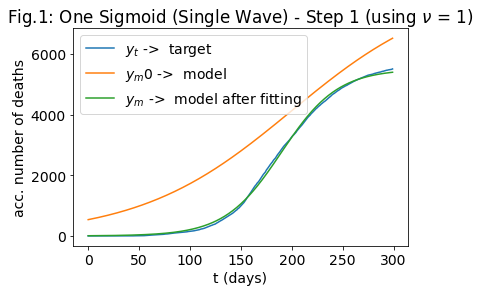

In [10]:
# Step 1 - Optimize a symmetric sigmoid (nu = 1)
y_t = acc_data[:n_days]
A0 = 1.5*max(y_t)
tp0 = (2/3)*len(y_t)
delta0 = (1/4)*len(y_t)
nu0 = 1
x0 = [A0, tp0, delta0, nu0]
sol = minimize(loss_f_sym, x0, constraints=cons, args=('MSE'), method='SLSQP')
print(sol)

# Optimal values
[A, tp, delta, nu] = sol.x

y_m0 = f_t(t[:n_days], A0, tp0, delta0, nu0)
y_m = f_t(t[:n_days], A, tp, delta, nu)
plt.title('Fig.1: One Sigmoid (Single Wave) - Step 1 (using $\\nu$ = 1)')
plt.plot(y_t, label='$y_t$ ->  target')
plt.plot(y_m0, label='$y_m0$ ->  model')
plt.plot(y_m, label='$y_m$ ->  model after fitting')
plt.xlabel('t (days)')
plt.ylabel('acc. number of deaths')
plt.legend()
plt.show()

     fun: 687.0036866123882
     jac: array([ 1.14440918e-04, -5.74493408e-03,  1.19781494e-03,  1.65596008e-01])
 message: 'Optimization terminated successfully'
    nfev: 86
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([5.75107374e+03, 1.82442586e+02, 3.77805732e+01, 3.79355602e-01])


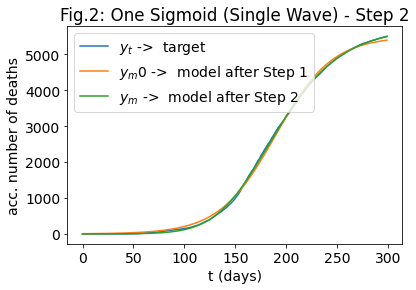

In [11]:
# Step 2 - Optimize an assymmetric sigmoid
# using optimal values of step 1 as the starting point
[A0, tp0, delta0, nu0] = sol.x

x0 = [A0, tp0, delta0, nu0]
sol = minimize(loss_f, x0, constraints=cons, args=('MSE'), method='SLSQP')
print(sol)

# Optimal values
[A, tp, delta, nu] = sol.x

y_t = acc_data[:n_days]
y_m0 = f_t(t[:n_days], A0, tp0, delta0, nu0)
y_m = f_t(t[:n_days], A, tp, delta, nu)
plt.title('Fig.2: One Sigmoid (Single Wave) - Step 2')
plt.plot(y_t, label='$y_t$ ->  target')
plt.plot(y_m0, label='$y_m0$ ->  model after Step 1')
plt.plot(y_m, label='$y_m$ ->  model after Step 2')
plt.xlabel('t (days)')
plt.ylabel('acc. number of deaths')
plt.legend()
plt.show()

### 2 - Múltiplas ondas epidemiológicas
Para fazer o ajuste do modelo para dados de N ondas epidemiológicas, utilizamos um modelo que envolve a soma de N sigmoides ($f(t)$).

![](https://i.imgur.com/YixfYwH.png)

[Escrever aqui um textinho mais elaborado documentando a lógica para múltiplas ondas]

In [12]:
a = []
a.append([1, 2, 3, 4])
a.append([5, 6, 7, 8])
print(a)
print(a[0])

[[1, 2, 3, 4], [5, 6, 7, 8]]
[1, 2, 3, 4]


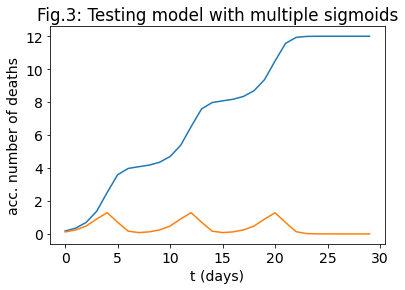

In [13]:
# Testing model for multiple sigmoids
n_days = 30
n_sig = 3
sig_params = [
    [4, 4, 0.5, 2.9],
    [4, 12, 0.5, 2.9]
]
[A, tp, delta, nu] = [4, 20, 0.5, 2.9]
plt.title('Fig.3: Testing model with multiple sigmoids')
plt.plot(model(t[:n_days], A, tp, delta, nu))
plt.plot(model_daily(t[:n_days], A, tp, delta, nu))
plt.xlabel('t (days)')
plt.ylabel('acc. number of deaths')
plt.show()

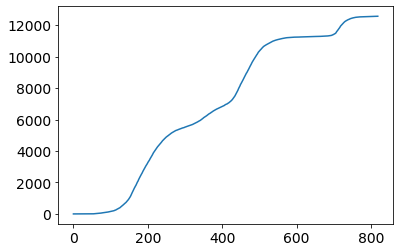

In [14]:
plt.plot(acc_data)

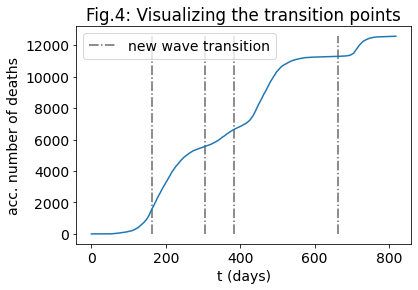

In [15]:
fig = plt.figure()
plt.plot(acc_data)
# Defini manualmente, por enquanto...
# pelo new_wave.py daria x_t [11, 101, 167, 254] (Jerusalem)
#x_nw = [90, 170, 240] #(Jerusalém)
#x_nw = [147, 287, 382, 669] #(SJC)
#x_nw = [84, 259, 314, 375, 688] # (SP)
#x_nw  = [94, 146, 269, 314, 377, 469, 607, 677, 741] # Campinas tr 2e-5
#x_nw = [8, 166, 226, 303, 375, 431, 590, 657] # Rosario - hosp - tr 1e-5
x_nw = [162, 306, 383, 663] # Rosario - obitos - tr 1e-5
#x_nw = [170, 391, 671] # Rosario - obitos - tr 3e-5
#x_nw = [101, 320, 410, 684] # Buenos Aires - obitos - tr 1e-5
#x_nw = [115, 418, 693] # Buenos Aires - obitos - tr 3e-5
#x_nw = [181, 323, 399, 438, 670] # Córdoba - obitos - tr 2e-5
#x_nw = [100, 149, 471, 610, 681, 741] # Camilas tr 3e-5

plt.title('Fig.4: Visualizing the transition points')
plt.vlines(x_nw, 0, max(acc_data), colors='dimgray', linestyles='dashdot', zorder=1, label="new wave transition")
plt.xlabel('t (days)')
plt.ylabel('acc. number of deaths')
plt.legend()
plt.show()


========= Wave nr 1 =========
From 0 to  162
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 97.71591852543418
     jac: array([ 2.19345093e-05, -1.05285645e-02,  2.48289108e-02,  0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 388
     nit: 70
    njev: 70
  status: 0
 success: True
       x: array([1.04772804e+04, 2.06348810e+02, 2.51726690e+01, 1.00000000e+00])
Step 2
     fun: 97.11697486464176
     jac: array([-0.00087357,  0.00049019, -0.00116825, -0.0251255 ])
 message: 'Optimization terminated successfully'
    nfev: 94
     nit: 17
    njev: 17
  status: 0
 success: True
       x: array([1.04772949e+04, 2.06794115e+02, 2.67443275e+01, 9.27646636e-01])


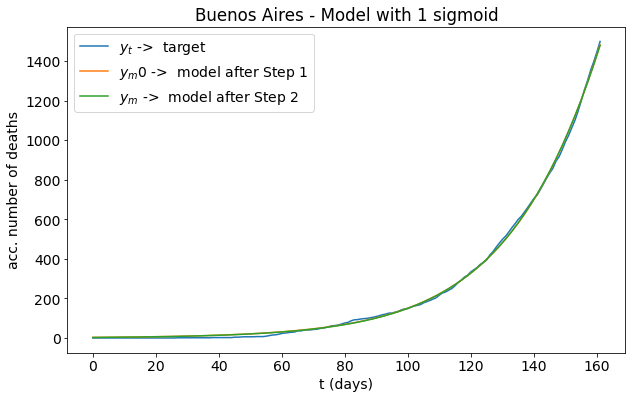

========= Wave nr 2 =========
From 0 to  306
Step 1
     fun: 4794448.740533403
     jac: array([0., 0., 0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 35
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([506.88173685, 556.19074184,  16.91782208,   1.        ])
Step 2
     fun: 4794448.647865166
     jac: array([0., 0., 0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 11
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([5.06881737e+02, 5.56190742e+02, 1.69178221e+01, 5.13574756e-01])


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


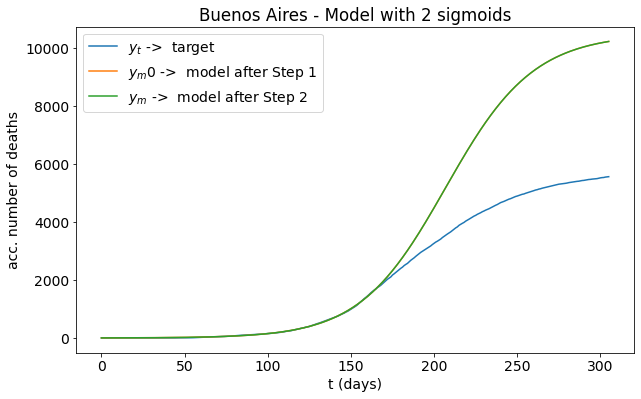

========= Wave nr 3 =========
From 0 to  383
Step 1
     fun: 7653541.359293554
     jac: array([0., 0., 0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 5
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([ 25.34408684, 656.19074184,  16.91782208,   1.        ])
Step 2
     fun: 7653541.359293554
     jac: array([0., 0., 0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 5
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([ 25.34408684, 656.19074184,  16.91782208,   1.        ])


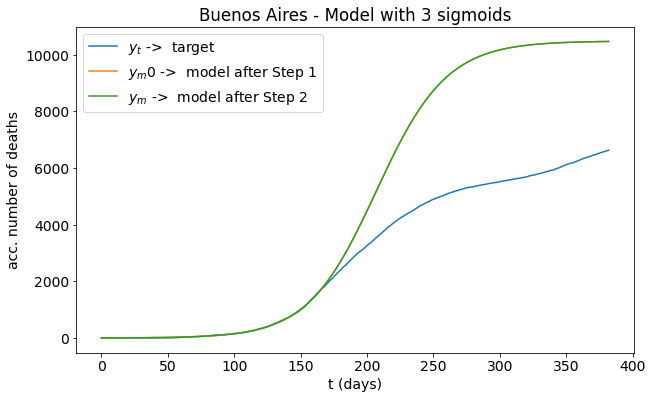

========= Wave nr 4 =========
From 0 to  663
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 5665350.875600669
     jac: array([0., 0., 0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 162
     nit: 29
    njev: 29
  status: 0
 success: True
       x: array([330.79910009, 512.74822062,   2.85726997,   1.        ])
Step 2


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in double_scalars
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 5665334.268528581
     jac: array([0.   , 0.   , 0.   , 2.375])
 message: 'Optimization terminated successfully'
    nfev: 59
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([3.31416377e+02, 5.10559332e+02, 4.39895592e+00, 1.00000000e-01])


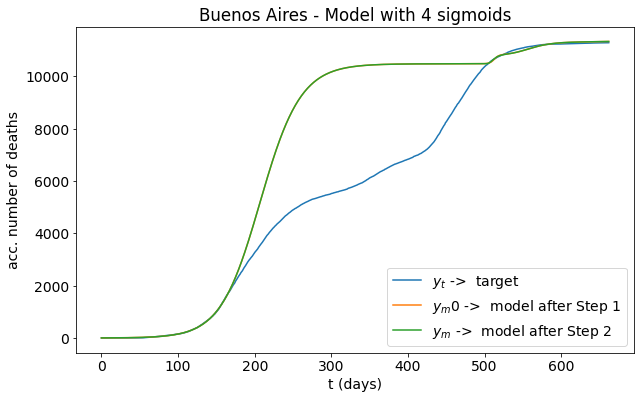

========= Wave nr 5 =========
From 0 to  805
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in double_scalars
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))
/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 4666207.768791231
     jac: array([0.    , 0.    , 0.0625, 0.    ])
 message: 'Optimization terminated successfully'
    nfev: 92
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([1.17861396e+03, 7.19563435e+02, 8.88639540e+00, 1.00000000e+00])
Step 2
     fun: 4666047.934039726
     jac: array([0.00000e+00, 6.25000e-02, 6.25000e-02, 8.85625e+01])
 message: 'Optimization terminated successfully'
    nfev: 70
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([1.19867204e+03, 7.14603423e+02, 1.31004559e+01, 1.00000000e-01])


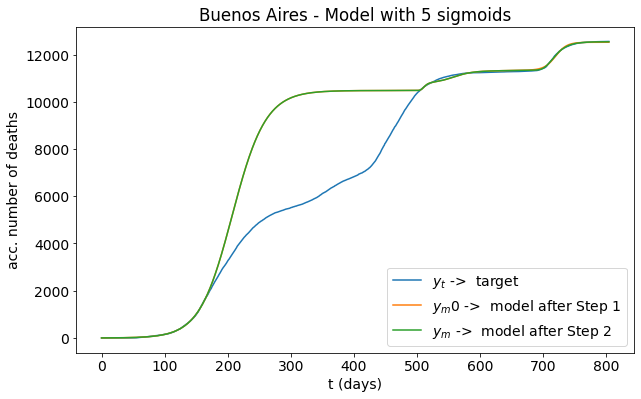

In [16]:
n_days = len(acc_data)
n_weeks_pred = 2
n_sig = 1
sig_params = []
for i in range(len(x_nw) + 1):
    if(i == len(x_nw)):
        n_days = len(acc_data) - 7*n_weeks_pred
    else:
        n_days = x_nw[i]
    print(f'========= Wave nr {i + 1} =========')
    print('From 0 to ', n_days)
    print('Step 1')
    # Step 1 - Optimize a symmetric sigmoid (nu = 1)
    # Initial values
    if(i == 0):
        y_t = acc_data[:n_days]
        A0 = 2*max(y_t)
        tp0 = (2/3)*len(y_t)
        delta0 = (1/4)*len(y_t)
        nu0 = 1
    else:
        tp0 += 100
        A0 *= 0.05
        #A0 *= 1.2
    # else:
    #     [A0, tp0, delta0, nu0] = sig_params[len(sig_params) - 1]
    #     tp0 = tp0 + 100
    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f_sym, x0, constraints=cons, args=('MSE'), method='SLSQP')
    print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    print('Step 2')
    # Step 2 - Optimize an assymmetric sigmoid
    # using optimal values of step 1 as the starting point
    [A0, tp0, delta0, nu0] = sol.x

    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f, x0, constraints=cons, args=('MSE'), method='SLSQP')
    print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    y_t = acc_data[:n_days]
    y_m0 = model(t[:n_days], A0, tp0, delta0, nu0)
    y_m = model(t[:n_days], A, tp, delta, nu)
    s = "" if (n_sig == 1) else "s"
    plt.figure(figsize=(10,6))
    plt.title(f'{city_name} - Model with {n_sig} sigmoid{s}')
    plt.plot(y_t, label='$y_t$ ->  target')
    plt.plot(y_m0, label='$y_m0$ ->  model after Step 1')
    plt.plot(y_m, label='$y_m$ ->  model after Step 2')
    plt.xlabel('t (days)')
    plt.ylabel('acc. number of deaths')
    plt.legend()
    plt.savefig(f'output/{i:003}', facecolor='white', dpi=100)
    plt.show()
    
    n_sig += 1
    sig_params.append([A, tp, delta, nu])
    print(f'===================================')    

819
819


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in double_scalars
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


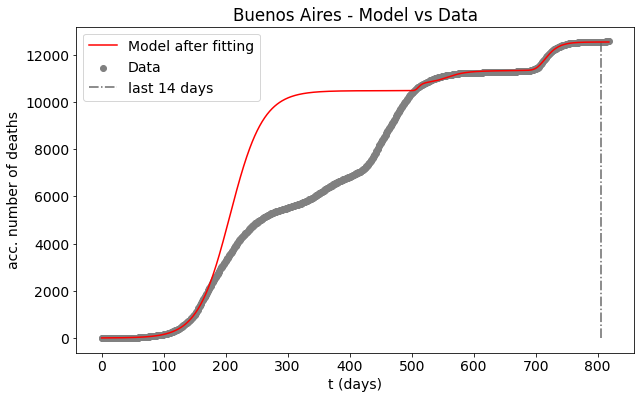

In [17]:
n_sig = 5
n_days = len(acc_data)
y_model = model(t[:n_days], A, tp, delta, nu)
print(len(y_model))
print(len(acc_data))
plt.figure(figsize=(10,6))
#plt.xlim(800, len(acc_data)+2)
plt.title(f'{city_name} - Model vs Data')
plt.scatter(t[:n_days], acc_data[:n_days], label='Data', c='gray')
plt.vlines(len(acc_data) - 7*n_weeks_pred, 0, max(acc_data), colors='dimgray', linestyles='dashdot', zorder=1, label=f"last {7*n_weeks_pred} days")
plt.plot(y_model, label='Model after fitting', c='r')
plt.xlabel('t (days)')
plt.ylabel('acc. number of deaths')
plt.legend()
plt.savefig(f'output/005', facecolor='white', dpi=100)
plt.show()
n_days = len(acc_data) -7*n_weeks_pred

In [18]:
#n_days = len(acc_data) - 7*n_weeks_pred
n_days = len(acc_data)

/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in double_scalars
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


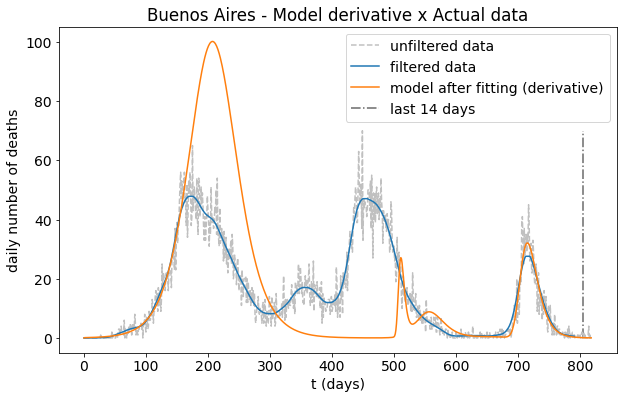

In [19]:
y_m = model(t, A, tp, delta, nu)

model_der = forward_euler(t[:n_days], 1, y_m[:n_days], 0)
#daily_data2 = forward_euler(t[:n_days], 1, acc_data[:n_days], 0)

plt.figure(figsize=(10, 6))
plt.title(f'{city_name} - Model derivative x Actual data')
plt.plot(daily_data, label="unfiltered data", c='silver', linestyle='dashed')
plt.plot(filter_data(daily_data), label="filtered data")
plt.plot(model_der, label='model after fitting (derivative)')
plt.vlines(len(acc_data) - 7*n_weeks_pred, 0, max(daily_data), colors='dimgray', linestyles='dashdot', zorder=1, label=f"last {7*n_weeks_pred} days")
plt.xlabel('t (days)')
plt.ylabel('daily number of deaths')
plt.savefig(f'output/{city_name}_der', facecolor='white', dpi=100)
plt.legend()
plt.show()

#### ===== Mudando apresentação dos resultados ======

In [20]:
#x_nw_orig = x_nw
#x_nw.append(len(acc_data))
#print(x_nw)
# x_nw = [101, 320, 410] 
x_nw_orig = x_nw

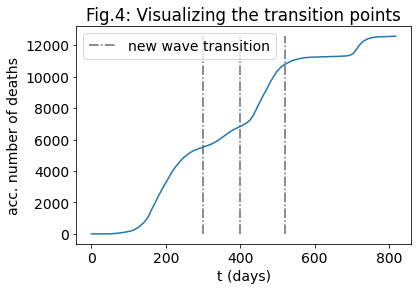

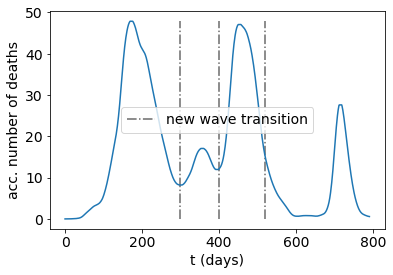

In [21]:
#x_nw = [101, 320, 410, 684] # Buenos Aires - obitos - tr 1e-5
#x_nw = [101, 320, 410]
#x_nw = [155, 299, 376, 656] 
#x_nw = [155, 299, 376] #(ficou bom)
#x_nw = [94, 313, 403, 677] # Buenos Aires - shift 27 filter
#x_nw = [94, 313, 403]
#x_nw = [295, 360, 515] # Manual Rosario
#x_nw = [300, 400, 520] # Manual Buenos Aires
#x_nw = [300, 400, 520] # Manual Mendoza
x_nw = [300, 400, 520] # Manual Córdoba
#x_nw = [265, 360, 480]
plt.title('Fig.4: Visualizing the transition points')
plt.vlines(x_nw, 0, max(acc_data), colors='dimgray', linestyles='dashdot', zorder=1, label="new wave transition")
plt.plot(acc_data)
plt.xlabel('t (days)')
plt.ylabel('acc. number of deaths')
plt.legend()
plt.show()
plt.vlines(x_nw, 0, max(filter_data(daily_data)), colors='dimgray', linestyles='dashdot', zorder=1, label="new wave transition")
plt.plot(filter_data(daily_data))
plt.xlabel('t (days)')
plt.ylabel('acc. number of deaths')
plt.legend()
plt.show()

========= Wave nr 1 =========
From 0 to  286
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 3360.566373137142
     jac: array([-0.00024414, -0.0007019 ,  0.00286865,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 144
     nit: 24
    njev: 24
  status: 0
 success: True
       x: array([5.43700999e+03, 1.88800602e+02, 2.72005021e+01, 1.00000000e+00])
Step 2
     fun: 719.2443620288894
     jac: array([ 9.91821289e-05, -3.98254395e-03, -1.50299072e-03,  5.10787964e-02])
 message: 'Optimization terminated successfully'
    nfev: 91
     nit: 17
    njev: 17
  status: 0
 success: True
       x: array([5.74499681e+03, 1.82457928e+02, 3.76515170e+01, 3.83543700e-01])


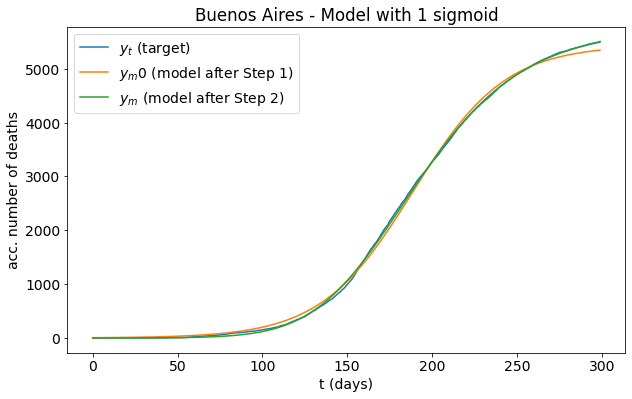

<Figure size 720x432 with 0 Axes>

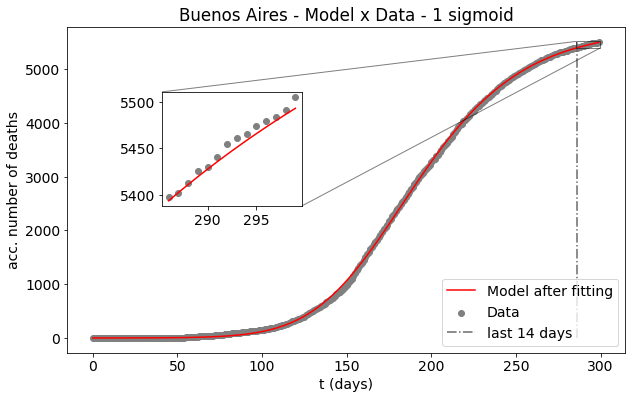

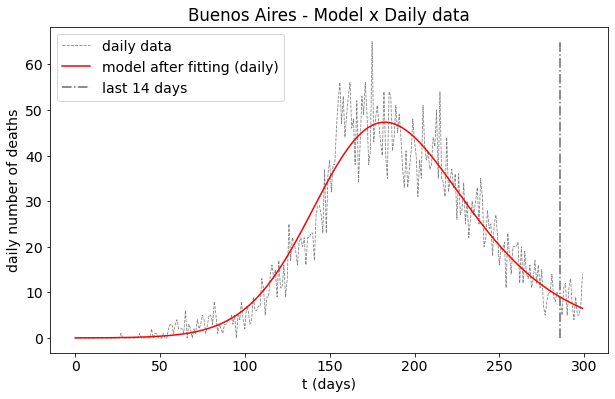

========= Wave nr 2 =========
From 0 to  386
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 552.2207484884266
     jac: array([4.57763672e-05, 7.85827637e-04, 2.97546387e-04, 0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 108
     nit: 20
    njev: 20
  status: 0
 success: True
       x: array([1.08834434e+03, 3.57425786e+02, 1.58262309e+01, 1.00000000e+00])
Step 2
     fun: 537.4331770992025
     jac: array([ 7.62939453e-05, -1.65557861e-03, -5.87463379e-04,  1.96380615e-02])
 message: 'Optimization terminated successfully'
    nfev: 137
     nit: 26
    njev: 26
  status: 0
 success: True
       x: array([1.32649031e+03, 3.58632359e+02, 2.59132876e+01, 3.42738808e-01])


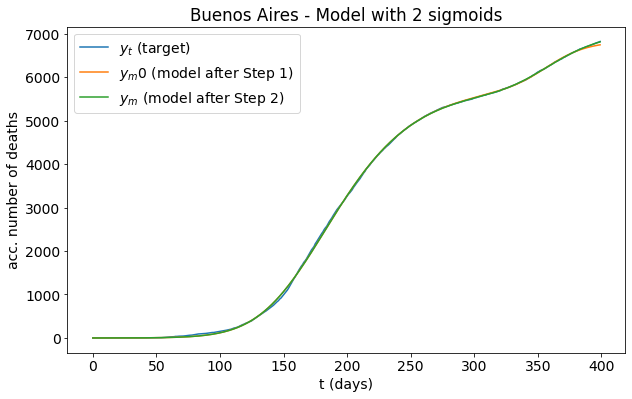

<Figure size 720x432 with 0 Axes>

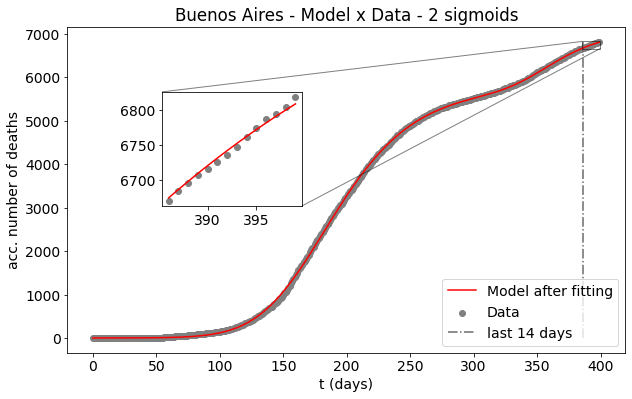

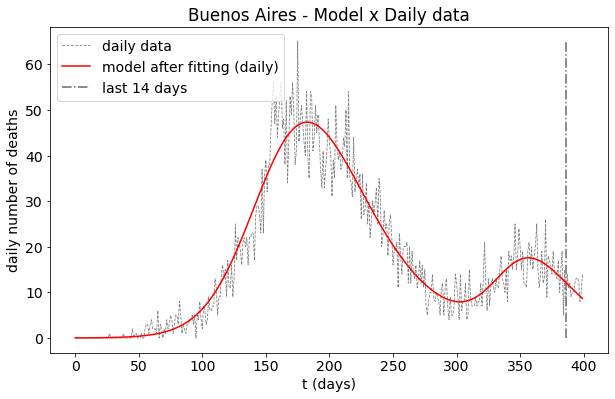

========= Wave nr 3 =========
From 0 to  506
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 1485.9598574067377
     jac: array([ 0.00024414, -0.00265503, -0.00427246,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 159
     nit: 28
    njev: 28
  status: 0
 success: True
       x: array([3.57198072e+03, 4.62927171e+02, 1.65495077e+01, 1.00000000e+00])
Step 2
     fun: 551.7094029109014
     jac: array([ 4.57763672e-05, -3.28826904e-03, -3.81469727e-03,  5.10865829e+02])
 message: 'Optimization terminated successfully'
    nfev: 106
     nit: 20
    njev: 20
  status: 0
 success: True
       x: array([4.25387871e+03, 4.59573430e+02, 3.05001953e+01, 1.00000000e-01])


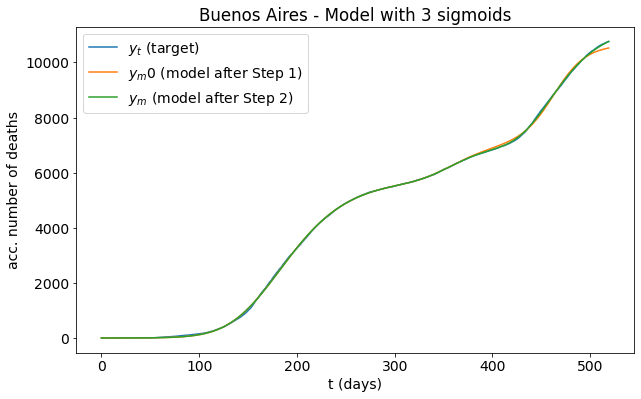

<Figure size 720x432 with 0 Axes>

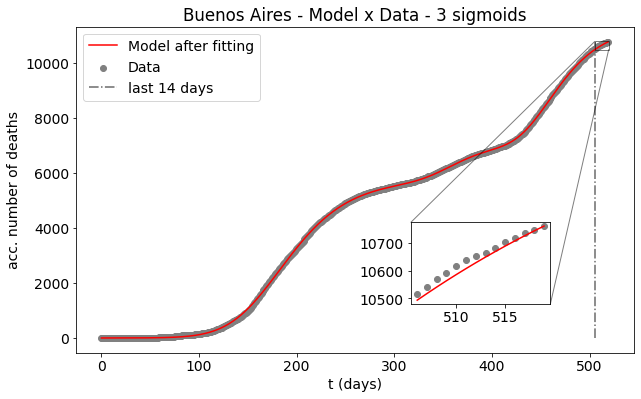

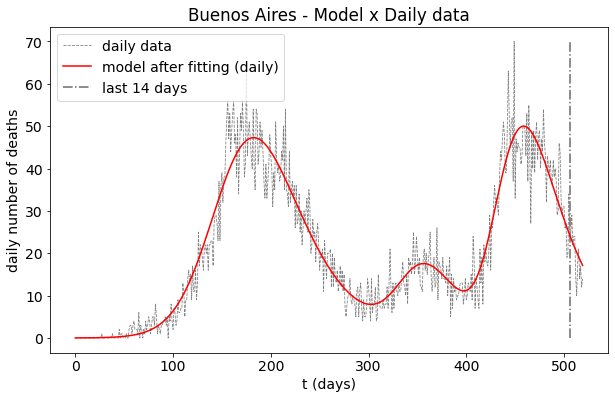

<Figure size 432x288 with 0 Axes>

In [22]:
n_weeks_pred = 2
n_sig = 1
sig_params = []

for i in range(len(x_nw)):
    x_nw[i]
    n_days = x_nw[i]- 7*n_weeks_pred
    print(f'========= Wave nr {i + 1} =========')
    print('From 0 to ', n_days)
    print('Step 1')
    # Step 1 - Optimize a symmetric sigmoid (nu = 1)
    # Initial values
    if(i == 0):
        y_t = acc_data[:n_days]
        A0 = 2*max(y_t)
        tp0 = (2/3)*len(y_t)
        delta0 = (1/4)*len(y_t)
        nu0 = 1
    else:
        tp0 += 100
        A0 *= 0.05
        #A0 *= 1.2
    # else:
    #     [A0, tp0, delta0, nu0] = sig_params[len(sig_params) - 1]
    #     tp0 = tp0 + 100
    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f_sym, x0, constraints=cons, args=('MSE'), method='SLSQP')
    print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    print('Step 2')
    # Step 2 - Optimize an assymmetric sigmoid
    # using optimal values of step 1 as the starting point
    [A0, tp0, delta0, nu0] = sol.x

    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f, x0, constraints=cons, args=('MSE'), method='SLSQP')
    print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    # due to filtering delay
    n_days = x_nw[i]


    y_t = acc_data[:n_days]
    y_m0 = model(t[:n_days], A0, tp0, delta0, nu0)
    y_m = model(t[:n_days], A, tp, delta, nu)
    y_m_daily = model_daily(t[:n_days], A, tp, delta, nu)
    s = "" if (n_sig == 1) else "s"
    plt.figure(figsize=(10,6))
    plt.title(f'{city_name} - Model with {n_sig} sigmoid{s}')
    plt.plot(y_t, label='$y_t$ (target)')
    plt.plot(y_m0, label='$y_m0$ (model after Step 1)')
    plt.plot(y_m, label='$y_m$ (model after Step 2)')
    plt.xlabel('t (days)')
    plt.ylabel('acc. number of deaths')
    plt.legend()
    #plt.savefig(f'output/{i:003}', facecolor='white', dpi=100)
    plt.show()

    # Plotting Model vs Data
    plt.figure(figsize=(10,6))
    fig, ax = plt.subplots(figsize=[10,6])
    #plt.xlim(x_nw[i] - 7*(n_weeks_pred + 1), x_nw[i])
    ax.set_title(f'{city_name} - Model x Data - {n_sig} sigmoid{s}')
    ax.scatter(t[:n_days], acc_data[:n_days], label='Data', c='gray')
    ax.vlines(n_days - 7*n_weeks_pred, 0, max(acc_data[:n_days]), colors='dimgray', linestyles='dashdot', zorder=1, label=f"last {7*n_weeks_pred} days")
    ax.plot(y_m, label='Model after fitting', c='r')
    ax.set_xlabel('t (days)')
    ax.set_ylabel('acc. number of deaths')
    ax.legend()
    X_detail = t[n_days - 7*n_weeks_pred: n_days]
    Y_detail = y_m[n_days - 7*n_weeks_pred: n_days]
    # detail prediction
    if(n_sig < 3):
        sub_axes = ax.inset_axes([.17, .45, .25, .35]) 
    else:
        sub_axes = ax.inset_axes([.6, .15, .25, .25]) 
    sub_axes.scatter(t[n_days - 7*n_weeks_pred:n_days], acc_data[n_days - 7*n_weeks_pred:n_days], label='Data', c='gray')
    sub_axes.plot(X_detail, Y_detail, c = 'r') 
    #sub_axes.set_xticks(X_detail[0::3])
    ax.indicate_inset_zoom(sub_axes, edgecolor="black")    
    plt.savefig(f'output/Acc_{city_name}_{n_sig}_sig', facecolor='white', dpi=100)
    plt.show()

    # Plotting Daily Data

    #daily_data = forward_euler(t[:n_days], 1, acc_data[:n_days], 0)
    # plt.figure(figsize=(10, 6))
    # plt.title(f'{city_name} - Model derivative x Actual data - {n_sig} sigmoid{s}')
    # plt.plot(daily_data[:n_days], label="unfiltered data", c='silver', linestyle='dashed')
    # plt.plot(moving_average(daily_data[:n_days], 7), label="filtered data")
    # plt.plot(y_m_daily, label='model after fitting (daily)')
    # plt.vlines(n_days - 7*n_weeks_pred, 0, max(daily_data[:n_days]), colors='dimgray', linestyles='dashdot', zorder=1, label=f"last {7*n_weeks_pred} days")
    # plt.xlabel('t (days)')
    # plt.ylabel('daily number of deaths')
    # plt.legend()
    # #plt.savefig(f'output/{city_name}_der_{n_sig}_wave', facecolor='white', dpi=100)
    # plt.show()

    # DAILY DATA
    plt.figure(figsize=(10, 6))
    
    plt.title(f'{city_name} - Model x Daily data')
    plt.plot(daily_data[:n_days], label="daily data", c='gray', lw=0.8, linestyle='dashed')
    plt.plot(y_m_daily, label='model after fitting (daily)', c='r')
    plt.vlines(n_days - 7*n_weeks_pred, 0, max(daily_data[:n_days]), colors='dimgray', linestyles='dashdot', zorder=1, label=f"last {7*n_weeks_pred} days")
    plt.xlabel('t (days)')
    plt.ylabel('daily number of deaths')
    plt.legend(loc=2) # upper left
    # plt.savefig(f'output/Daily_{city_name}_{n_sig}_wave', facecolor='white', dpi=100)
    plt.show()


    
    n_sig += 1
    sig_params.append([A, tp, delta, nu])
    print(f'===================================')    

plt.tight_layout()
plt.savefig(f'output/Daily_{city_name}_2w_pred', facecolor='white', dpi=100)
plt.show()


========= Wave nr 1 =========
From 0 to  286
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 3360.566373137142
     jac: array([-0.00024414, -0.0007019 ,  0.00286865,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 144
     nit: 24
    njev: 24
  status: 0
 success: True
       x: array([5.43700999e+03, 1.88800602e+02, 2.72005021e+01, 1.00000000e+00])
Step 2
     fun: 719.2443620288894
     jac: array([ 9.91821289e-05, -3.98254395e-03, -1.50299072e-03,  5.10787964e-02])
 message: 'Optimization terminated successfully'
    nfev: 91
     nit: 17
    njev: 17
  status: 0
 success: True
       x: array([5.74499681e+03, 1.82457928e+02, 3.76515170e+01, 3.83543700e-01])
========= Wave nr 2 =========
From 0 to  386
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 552.2207484884266
     jac: array([4.57763672e-05, 7.85827637e-04, 2.97546387e-04, 0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 108
     nit: 20
    njev: 20
  status: 0
 success: True
       x: array([1.08834434e+03, 3.57425786e+02, 1.58262309e+01, 1.00000000e+00])
Step 2
     fun: 537.4331770992025
     jac: array([ 7.62939453e-05, -1.65557861e-03, -5.87463379e-04,  1.96380615e-02])
 message: 'Optimization terminated successfully'
    nfev: 137
     nit: 26
    njev: 26
  status: 0
 success: True
       x: array([1.32649031e+03, 3.58632359e+02, 2.59132876e+01, 3.42738808e-01])
========= Wave nr 3 =========
From 0 to  506
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 1485.9598574067377
     jac: array([ 0.00024414, -0.00265503, -0.00427246,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 159
     nit: 28
    njev: 28
  status: 0
 success: True
       x: array([3.57198072e+03, 4.62927171e+02, 1.65495077e+01, 1.00000000e+00])
Step 2
     fun: 551.7094029109014
     jac: array([ 4.57763672e-05, -3.28826904e-03, -3.81469727e-03,  5.10865829e+02])
 message: 'Optimization terminated successfully'
    nfev: 106
     nit: 20
    njev: 20
  status: 0
 success: True
       x: array([4.25387871e+03, 4.59573430e+02, 3.05001953e+01, 1.00000000e-01])


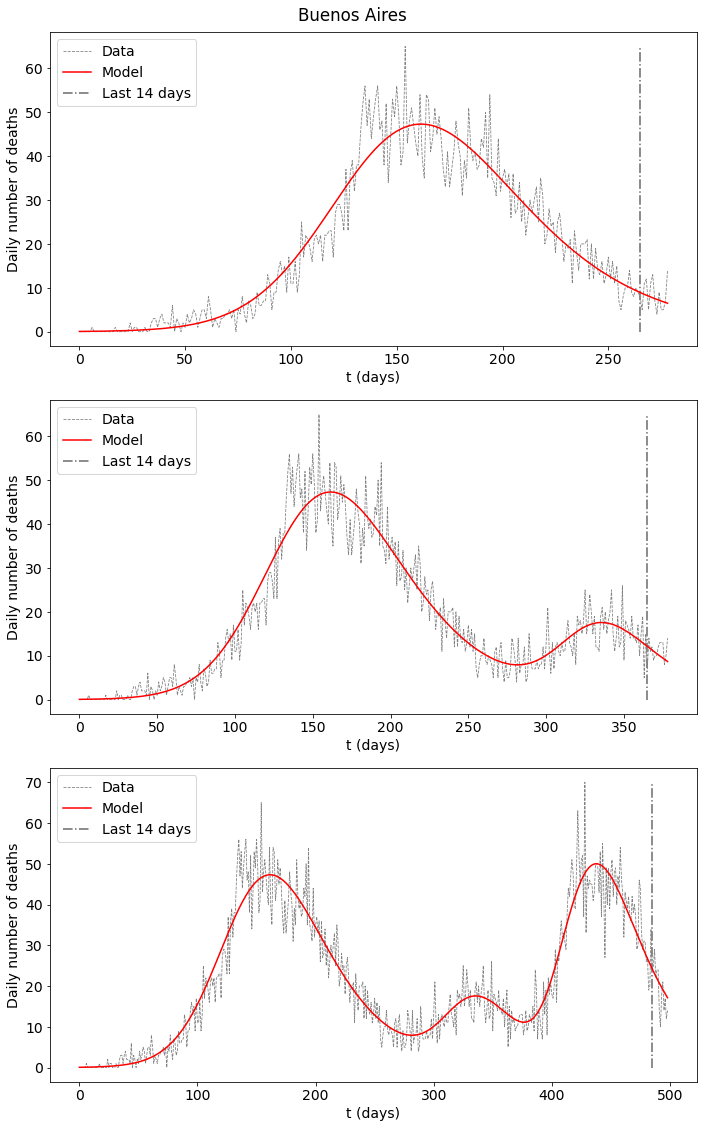

In [46]:
n_weeks_pred = 2
n_sig = 1
sig_params = []

fig, axs = plt.subplots(3, 1, figsize=(10,16))
#fig.suptitle(f'{city_name} - Model x Daily number of deaths')
fig.suptitle(f'{city_name}')
for i in range(len(x_nw)):
    x_nw[i]
    n_days = x_nw[i]- 7*n_weeks_pred
    print(f'========= Wave nr {i + 1} =========')
    print('From 0 to ', n_days)
    print('Step 1')
    # Step 1 - Optimize a symmetric sigmoid (nu = 1)
    # Initial values
    if(i == 0):
        y_t = acc_data[:n_days]
        A0 = 2*max(y_t)
        tp0 = (2/3)*len(y_t)
        delta0 = (1/4)*len(y_t)
        nu0 = 1
    else:
        tp0 += 100
        A0 *= 0.05
        #A0 *= 1.2
    # else:
    #     [A0, tp0, delta0, nu0] = sig_params[len(sig_params) - 1]
    #     tp0 = tp0 + 100
    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f_sym, x0, constraints=cons, args=('MSE'), method='SLSQP')
    print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    print('Step 2')
    # Step 2 - Optimize an assymmetric sigmoid
    # using optimal values of step 1 as the starting point
    [A0, tp0, delta0, nu0] = sol.x

    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f, x0, constraints=cons, args=('MSE'), method='SLSQP')
    print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    # due to filtering delay
    n_days = x_nw[i]


    y_t = acc_data[:n_days]
    y_m0 = model(t[:n_days], A0, tp0, delta0, nu0)
    y_m = model(t[:n_days], A, tp, delta, nu)
    y_m_daily = model_daily(t[:n_days], A, tp, delta, nu)
    s = "" if (n_sig == 1) else "s"
    # plt.figure(figsize=(10,6))
    # plt.title(f'{city_name} - Model with {n_sig} sigmoid{s}')
    # plt.plot(y_t, label='$y_t$ (target)')
    # plt.plot(y_m0, label='$y_m0$ (model after Step 1)')
    # plt.plot(y_m, label='$y_m$ (model after Step 2)')
    # plt.xlabel('t (days)')
    # plt.ylabel('acc. number of deaths')
    # plt.legend()
    # #plt.savefig(f'output/{i:003}', facecolor='white', dpi=100)
    # plt.show()

    # Plotting Model vs Data
    #plt.figure(figsize=(10,6))
    # fig, ax = plt.subplots(figsize=[10,6])
    # #plt.xlim(x_nw[i] - 7*(n_weeks_pred + 1), x_nw[i])
    # ax.set_title(f'{city_name} - Model x Data - {n_sig} sigmoid{s}')
    # ax.scatter(t[:n_days], acc_data[:n_days], label='Data', c='gray')
    # ax.vlines(n_days - 7*n_weeks_pred, 0, max(acc_data[:n_days]), colors='dimgray', linestyles='dashdot', zorder=1, label=f"last {7*n_weeks_pred} days")
    # ax.plot(y_m, label='Model after fitting', c='r')
    # ax.set_xlabel('t (days)')
    # ax.set_ylabel('acc. number of deaths')
    # ax.legend()
    # X_detail = t[n_days - 7*n_weeks_pred: n_days]
    # Y_detail = y_model[n_days - 7*n_weeks_pred: n_days]
    # # detail prediction
    # if(n_sig < 3):
    #     sub_axes = ax.inset_axes([.17, .45, .25, .35]) 
    # else:
    #     sub_axes = ax.inset_axes([.6, .15, .25, .25]) 
    # sub_axes.scatter(t[n_days - 7*n_weeks_pred:n_days], acc_data[n_days - 7*n_weeks_pred:n_days], label='Data', c='gray')
    # sub_axes.plot(X_detail, Y_detail, c = 'r') 
    # #sub_axes.set_xticks(X_detail[0::3])
    # ax.indicate_inset_zoom(sub_axes, edgecolor="black")    
    # plt.savefig(f'output/Acc_{city_name}_{n_sig}_sig', facecolor='white', dpi=100)
    # plt.show()

    # Plotting Daily Data

    #daily_data = forward_euler(t[:n_days], 1, acc_data[:n_days], 0)
    # plt.figure(figsize=(10, 6))
    # plt.title(f'{city_name} - Model derivative x Actual data - {n_sig} sigmoid{s}')
    # plt.plot(daily_data[:n_days], label="unfiltered data", c='silver', linestyle='dashed')
    # plt.plot(moving_average(daily_data[:n_days], 7), label="filtered data")
    # plt.plot(y_m_daily, label='model after fitting (daily)')
    # plt.vlines(n_days - 7*n_weeks_pred, 0, max(daily_data[:n_days]), colors='dimgray', linestyles='dashdot', zorder=1, label=f"last {7*n_weeks_pred} days")
    # plt.xlabel('t (days)')
    # plt.ylabel('daily number of deaths')
    # plt.legend()
    # #plt.savefig(f'output/{city_name}_der_{n_sig}_wave', facecolor='white', dpi=100)
    # plt.show()

    # DAILY DATA
    #plt.figure(figsize=(10, 6))
    
    #plt.title(f'{city_name} - Model x Daily data')
    
    shift_val = 21 # Buenos Aires

    #daily_data = np.array(daily_data)
    #daily_data_masked = np.ma.masked_where( t < 21, daily_data) 

    #y_m_daily = np.array(y_m_daily)
    #y_m_daily_masked = np.ma.masked_where( t[:n_days] < 21, y_m_daily) 


    axs[i].plot(daily_data[shift_val:n_days], label="Data", c='gray', lw=0.8, linestyle='dashed')
    axs[i].plot(y_m_daily[shift_val:], label='Model', c='r')
    axs[i].vlines(n_days - 7*n_weeks_pred - shift_val, 0, max(daily_data[:n_days]), colors='dimgray', linestyles='dashdot', zorder=1, label=f"Last {7*n_weeks_pred} days")
    axs[i].set_xlabel('t (days)')
    axs[i].set_ylabel('Daily number of deaths')
    axs[i].legend(loc=2) # upper left
    # plt.savefig(f'output/Daily_{city_name}_{n_sig}_wave', facecolor='white', dpi=100)
    # plt.show()


    
    n_sig += 1
    sig_params.append([A, tp, delta, nu])
    print(f'===================================')    

plt.tight_layout()
plt.savefig(f'output/Daily_{city_name}_2w_pred', facecolor='white', dpi=100)
plt.show()


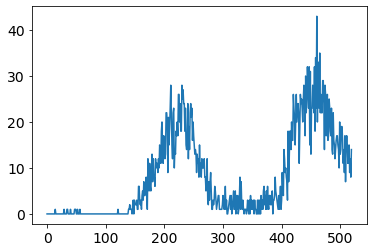

In [20]:
plt.plot(daily_data[:n_days])

In [21]:
n_sig

4

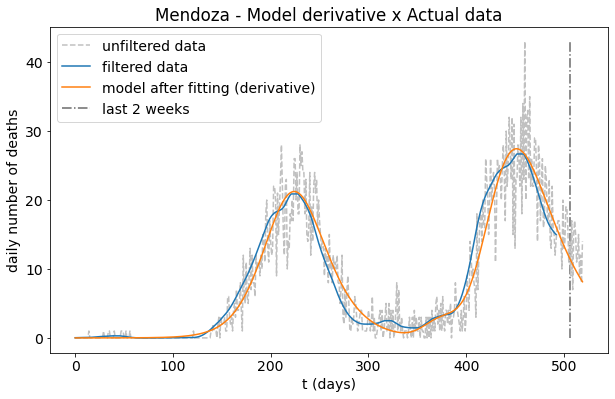

In [22]:
n_sig = 3
y_m = model(t, A, tp, delta, nu)

model_der = forward_euler(t[:n_days], 1, y_m[:n_days], 0)
daily_data = forward_euler(t[:n_days], 1, acc_data[:n_days], 0)

plt.figure(figsize=(10, 6))
plt.title(f'{city_name} - Model derivative x Actual data')
plt.plot(daily_data, label="unfiltered data", c='silver', linestyle='dashed')
plt.plot(filter_data(daily_data), label="filtered data")
plt.plot(model_der, label='model after fitting (derivative)')
plt.vlines(n_days - 7*n_weeks_pred, 0, max(daily_data), colors='dimgray', linestyles='dashdot', zorder=1, label=f"last {n_weeks_pred} weeks")
plt.xlabel('t (days)')
plt.ylabel('daily number of deaths')
plt.savefig(f'output/{city_name}_der', facecolor='white', dpi=100)
plt.legend()
plt.show()

#### ===== Rascunho (testes para melhor entendimento) =====

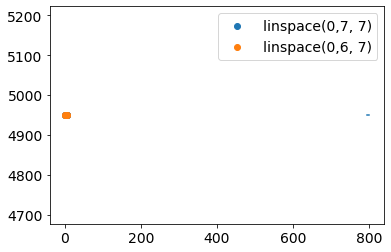

In [23]:
plt.plot(acc_data[len(acc_data)-7:])
plt.scatter(np.linspace(0,7, 7), acc_data[len(acc_data)-7:], label='linspace(0,7, 7)')
plt.scatter(np.linspace(0,6, 7), acc_data[len(acc_data)-7:], label='linspace(0,6, 7)')
plt.legend()
plt.show()


In [24]:
X_detail[0::3]

array([506., 509., 512., 515., 518.])

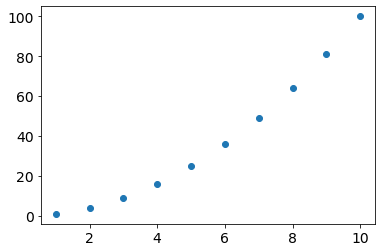

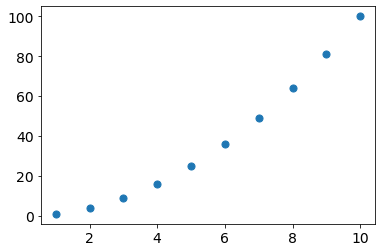

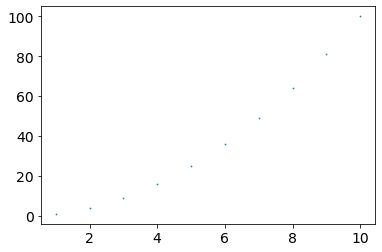

In [25]:
a = np.linspace(1, 10, 10)
plt.scatter(a, a**2)
plt.show()
plt.scatter(a, a**2, s=50)
plt.show()
plt.scatter(a, a**2, s=0.5)
plt.show()

In [26]:
[(5-i)*0.05 for i in range(0,5)]

[0.25, 0.2, 0.15000000000000002, 0.1, 0.05]

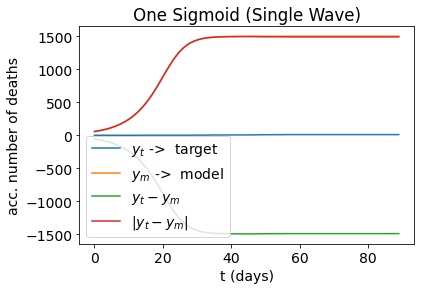

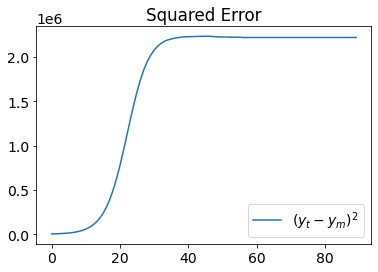

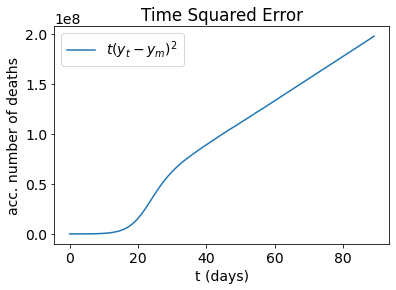

In [27]:
n_sig = 1
n_days = 90
# Initialize model parameters
A = 1500
tp = 20
delta = 3.1
nu = 2.2

y_t = acc_data[:n_days]
y_m = f_t(t[:n_days], A, tp, delta, nu)
plt.title('One Sigmoid (Single Wave)')
plt.plot(y_t, label='$y_t$ ->  target')
plt.plot(y_m, label='$y_m$ ->  model')
plt.plot(y_t - y_m, label='$y_t - y_m$')
plt.plot(abs(y_t - y_m), label='|$y_t - y_m$|')
plt.xlabel('t (days)')
plt.ylabel('acc. number of deaths')
plt.legend()
plt.show()
plt.title('Squared Error')
plt.plot((y_t - y_m)**2, label='$(y_t - y_m)^2$')
plt.legend()
plt.show()
plt.title('Time Squared Error')
plt.plot(t[:n_days]*(y_t - y_m)**2, label='$t(y_t - y_m)^2$')
plt.xlabel('t (days)')
plt.ylabel('acc. number of deaths')
plt.legend()
plt.show()


In [28]:
# Fazendo testes com múltiplas ondas
# Modelo envolvendo soma de sigmoides assimétricas 
n_sig = 4
x = np.random.rand(4*n_sig)
x

array([0.23217493, 0.67228754, 0.81875067, 0.48041228, 0.22754068,
       0.9515818 , 0.04346594, 0.56549506, 0.49418672, 0.40979312,
       0.73636182, 0.10391101, 0.33376724, 0.90364298, 0.9485519 ,
       0.41316232])

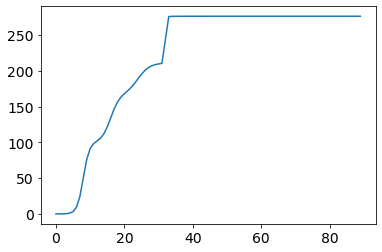

In [29]:
# Antigo... ignorar
n_sig = 4
# inicialização aleatória
x = np.random.rand(4*n_sig)
sigsum = np.zeros(n_days)
for i in range(n_sig):
    A = 1e2*x[i + 0]
    tp = 8*(i+1)
    delta = 2*x[i + 2]
    nu = 1
    sigsum += f_t(t[:n_days], A, tp, delta, nu)
plt.plot(sigsum)
plt.show()